In [1]:
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
import scipy as sc
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from matplotlib import cm
#from scipy.stats import gaussian_kde
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Behavioral Analysis

### Import data in pandas dataframe
Importing of data of finished and unfinished path

In [2]:
df_finished_paths = pd.read_csv('Dataset\wikispeedia_paths-and-graph.tar\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_finished.tsv', 
                                  sep='\t', 
                                  skiprows=16,
                                  names = ["hashedIpAddress","timestamp","durationInSec","path","rating"],)

'Dataset/wikispeedia_paths-and-graph.tar/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv'

df_finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [14]:
df_unfinished_paths = pd.read_csv('Dataset\wikispeedia_paths-and-graph.tar\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_unfinished.tsv', 
                                  sep='\t', 
                                  skiprows=17,
                                  names = ["hashedIpAddress","timestamp","durationInSec","path","target","type"],)
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [17]:

print(np.shape(df_finished_paths))
print(np.shape(df_unfinished_paths))

(51318, 5)
(24875, 6)


In [12]:
N=100

### Wrangling Data:
First, for the number of game played depending on the number of wins and losses, the number of wins and loss per players should be counted.
Players are differentiated using their Ip adress.

Dataframe "df_nbr_games" summarises the number of game winned, lost and played per player. 

In [18]:
df_finished_paths['nbr_win'] = df_finished_paths.groupby('hashedIpAddress')['hashedIpAddress'].transform('count')
df_finished_paths.head(5)

,hashedIpAddress,timestamp,durationInSec,path,rating,nbr_win
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,4.0
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,13.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,43.0
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3.0
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,8.0


In [19]:
df_unfinished_paths['nbr_loss'] = df_unfinished_paths.groupby('hashedIpAddress')['hashedIpAddress'].transform('count')
>>> df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,nbr_loss
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,1
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,1
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,1
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2


In [20]:
df_nbr_games = df_finished_paths[["hashedIpAddress",'nbr_win']].drop_duplicates().merge(df_unfinished_paths[['hashedIpAddress','nbr_loss']].drop_duplicates(),
                                                                                        how = "outer",
                                                                                        on="hashedIpAddress")
df_nbr_games = df_nbr_games.fillna(0)
df_nbr_games['nbr_play'] = df_nbr_games['nbr_win'] + df_nbr_games['nbr_loss']
df_nbr_games.head()

,hashedIpAddress,nbr_win,nbr_loss,nbr_play
0,6a3701d319fc3754,4.0,4.0,8.0
1,3824310e536af032,13.0,8.0,21.0
2,415612e93584d30e,43.0,37.0,80.0
3,64dd5cd342e3780c,3.0,0.0,3.0
4,015245d773376aab,8.0,0.0,8.0


In [21]:
#print(reg.intercept_, reg.coef_, reg.score(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play']))

### Plotting
Plot of the analysis using a scatter plot and a linear regression.

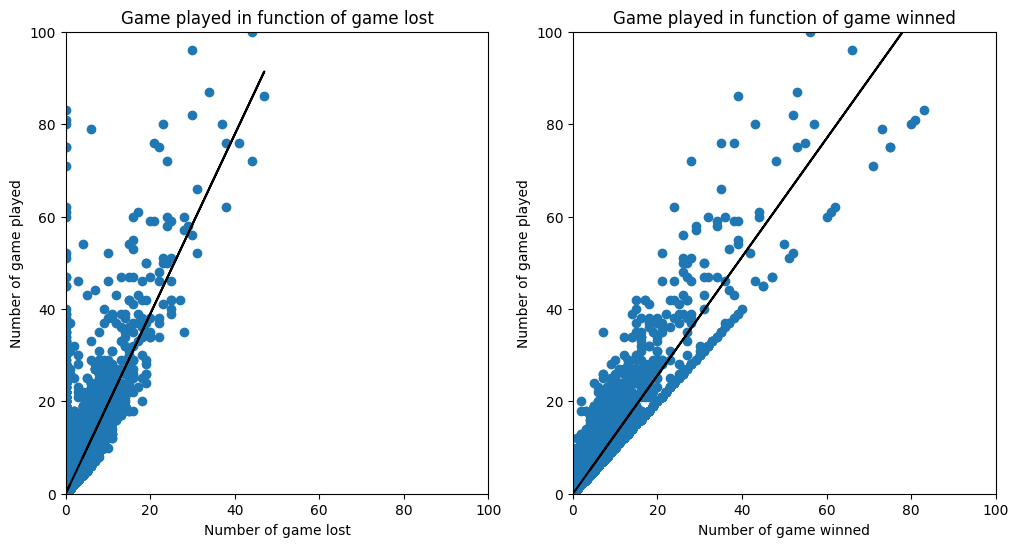

In [22]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

df_lim100 = df_nbr_games[df_nbr_games["nbr_play"]<=100]

#Linear regression calculator
regression_loss = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play'])
axs[0].plot(df_lim100['nbr_loss'],regression_loss.predict(np.array(df_lim100['nbr_loss']).reshape(-1, 1)),'-k')

regression_win = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['nbr_win']).reshape(-1, 1),df_lim100['nbr_play'])
axs[1].plot(df_lim100['nbr_win'],regression_win.predict(np.array(df_lim100['nbr_win']).reshape(-1, 1)),'-k')

#Density calculator:
"""xy_loss = np.vstack([df_nbr_games['nbr_loss'],df_nbr_games['nbr_play']])
density_loss = gaussian_kde(xy_loss)(xy_loss)
xy_win = np.vstack([df_nbr_games['nbr_win'],df_nbr_games['nbr_play']])
density_win = gaussian_kde(xy_win)(xy_win)"""

#Plotting
axs[0].scatter(df_nbr_games['nbr_loss'],df_nbr_games['nbr_play'])
axs[0].set_title("Game played in function of game lost")
axs[0].set_xlabel("Number of game lost")
axs[0].set_ylabel("Number of game played")
axs[0].set_ylim((0,100))
axs[0].set_xlim((0,100))


axs[1].scatter(df_nbr_games['nbr_win'],df_nbr_games['nbr_play'])
axs[1].set_title("Game played in function of game winned")
axs[1].set_xlabel("Number of game winned")
axs[1].set_ylabel("Number of game played")
axs[1].set_xlim((0,100))
axs[1].set_ylim((0,100))


plt.show()

In [23]:
coeff_loss = regression_loss.coef_[0]
R2_loss = regression_loss.score(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play'])
coeff_win = regression_win.coef_[0]
R2_win = regression_win.score(np.array(df_lim100['nbr_win']).reshape(-1, 1),df_lim100['nbr_play'])
print('Slope Coefficient for loss: %.2f \n R^2 loss: %.5f' % (coeff_loss,R2_loss))
print('Slope Coefficient for win: %.2f \n R^2 win: %.5f'% (coeff_win,R2_win))
print('Mean number of game per player: %.2f'%(df_nbr_games['nbr_play'].mean()))

Slope Coefficient for loss: 1.94 
 R^2 loss: 0.46341
Slope Coefficient for win: 1.28 
 R^2 win: 0.83998
Mean number of game per player: 3.65


From the slope results above, when someone plays a game and lose it he usually plays another 0.94 games. We can round it to asssume that, after losing a game players often plays another one.

On the other hand, people play in average 1.28 games if winning. 

Therefore, from a comportemental point of view, a player tend to play more if losing than if winning. From a reward point of view, losing have a bigger impact on player's interest for the game, which fits researches. 

Following line shows that by only taking players that played 100 times or less, we discarded only 23 players, we consider them as outliers.

We also show how much games were played per person.

In [24]:
print("Players discarded when reducing to 100 game played: %.f" %(np.shape(df_nbr_games)[0]-np.shape(df_lim100)[0]))

Players discarded when reducing to 100 game played: 23


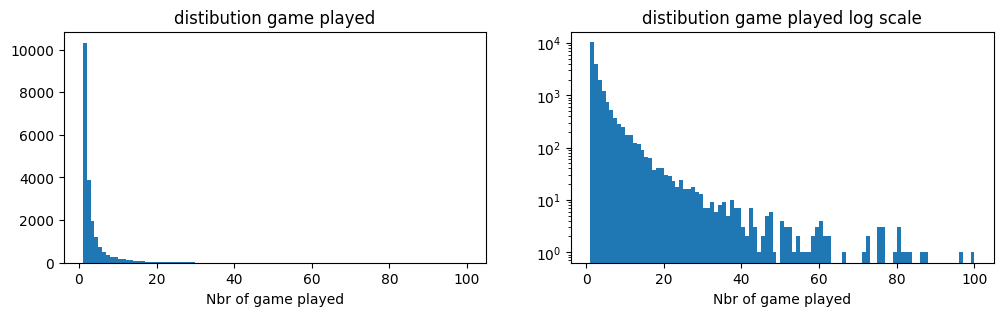

In [25]:
fig,axs = plt.subplots(1,2,figsize = (12,3))

axs[0].hist(df_lim100["nbr_play"],bins = np.arange(1,101,1))
axs[0].set_title("distibution game played")
axs[0].set_xlabel("Nbr of game played")

axs[1].hist(df_lim100["nbr_play"],bins = np.arange(1,101,1))
axs[1].set_title("distibution game played log scale")
axs[1].set_yscale("log")
axs[1].set_xlabel("Nbr of game played")
#axs[1].set_xscale("log")
plt.show()

### Time spent playing analysis
The following analysis follows the same idea as in the first one but using time spent. We use the fact that a game winned is the winning time and for lost game, losing time.

A player can lose by two ways: he either lose by restarting or by "giving up" when he don't do anything for half an hour. Because we want as losing time the time spent losing, we need to remove 30min for each timeout on the total time to be sure that the player is actively playing.

In [26]:
#datafame for winning_time:
df_finished_paths['time_spent_winning'] = df_finished_paths.groupby('hashedIpAddress')['durationInSec'].transform('sum')

#datafame for losing time:
df_unfinished_paths['time_spent'] = df_unfinished_paths.groupby('hashedIpAddress')['durationInSec'].transform('sum')
df_unfinished_paths['nbr_timeout'] = df_unfinished_paths[df_unfinished_paths['type']=='timeout'].groupby('hashedIpAddress')['type'].transform('count')
df_unfinished_paths['nbr_timeout'] = df_unfinished_paths.groupby('hashedIpAddress')['nbr_timeout'].transform('mean')
df_unfinished_paths = df_unfinished_paths.fillna(0)
df_unfinished_paths['time_spent_losing'] = df_unfinished_paths['time_spent'] - df_unfinished_paths['nbr_timeout'] * 1800 
#4 times the timeout happened before 30min, leading to a negative time sprent, put those numbers back to 0.
df_unfinished_paths[df_unfinished_paths['time_spent_losing']<0] = 0
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,nbr_loss,time_spent,nbr_timeout,time_spent_losing
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,1,1804,1.0,4.0
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,1,1805,1.0,5.0
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,1,1818,1.0,18.0
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2,1857,1.0,57.0
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2,1857,1.0,57.0


In [71]:
# Add new time data in previous dataframe:
df_time_games = df_finished_paths[["hashedIpAddress",'time_spent_winning']].drop_duplicates().merge(
                                                                                        df_unfinished_paths[['hashedIpAddress','time_spent_losing']].drop_duplicates(),
                                                                                        how = "outer",
                                                                                        on="hashedIpAddress")
df_time_games = df_time_games.fillna(0)
df_time_games["time_played"] = df_time_games['time_spent_winning'] + df_time_games['time_spent_losing']

df_nbr_games = df_nbr_games.merge(df_time_games, how="outer", on="hashedIpAddress")
df_nbr_games = df_nbr_games.fillna(0)
df_nbr_games.head()

C:\Users\Antoine\AppData\Local\Temp\ipykernel_19980\4003644421.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_played_x', 'time_spent_losing_x', 'time_spent_winning_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_nbr_games = df_nbr_games.merge(df_time_games, how="outer", on="hashedIpAddress")


,hashedIpAddress,nbr_win,nbr_loss,nbr_play,time_spent_winning_x,time_spent_losing_x,time_played_x,time_spent_winning_y,time_spent_losing_y,time_played_y,time_spent_winning_x,time_spent_losing_x,time_played_x,time_spent_winning_y,time_spent_losing_y,time_played_y
0,6a3701d319fc3754,4.0,4.0,8.0,783.0,644.0,1427.0,783.0,644.0,1427.0,783.0,644.0,1427.0,783.0,644.0,1427.0
1,3824310e536af032,13.0,8.0,21.0,1300.0,1287.0,2587.0,1300.0,1287.0,2587.0,1300.0,1287.0,2587.0,1300.0,1287.0,2587.0
2,415612e93584d30e,43.0,37.0,80.0,3083.0,3601.0,6684.0,3083.0,3601.0,6684.0,3083.0,3601.0,6684.0,3083.0,3601.0,6684.0
3,64dd5cd342e3780c,3.0,0.0,3.0,277.0,0.0,277.0,277.0,0.0,277.0,277.0,0.0,277.0,277.0,0.0,277.0
4,015245d773376aab,8.0,0.0,8.0,1535.0,0.0,1535.0,1535.0,0.0,1535.0,1535.0,0.0,1535.0,1535.0,0.0,1535.0


### Plotting
Plot of the analysis using a scatter plot and a linear regression.

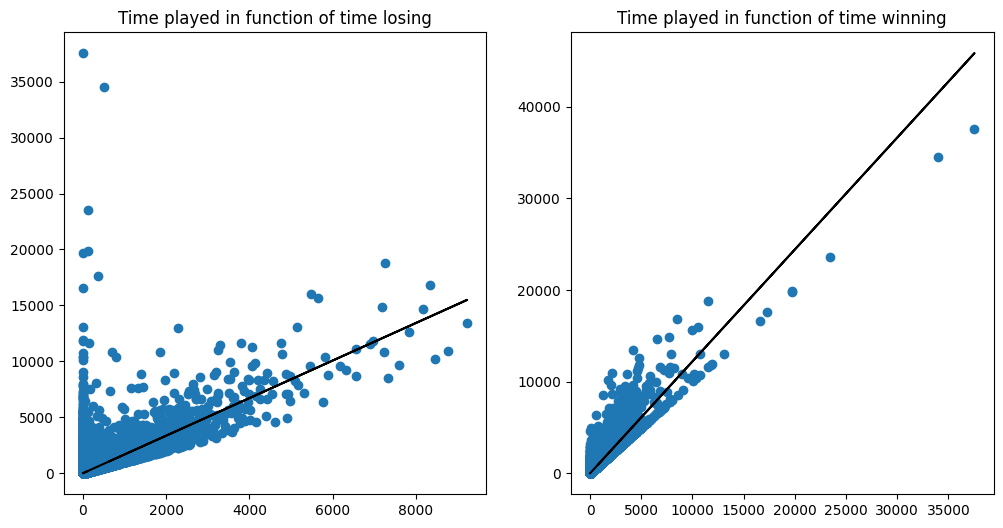

In [28]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

df_lim100 = df_nbr_games[df_nbr_games["nbr_play"]<=100]

# Linear Regression computation
regression_loss_t = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['time_spent_losing']).reshape(-1, 1),df_lim100['time_played'])
axs[0].plot(df_lim100['time_spent_losing'],regression_loss_t.predict(np.array(df_lim100['time_spent_losing']).reshape(-1, 1)),'-k')

regression_win_t = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['time_spent_winning']).reshape(-1, 1),df_lim100['time_played'])
axs[1].plot(df_lim100['time_spent_winning'],regression_win_t.predict(np.array(df_lim100['time_spent_winning']).reshape(-1, 1)),'-k')

#Plot
axs[0].scatter(df_lim100['time_spent_losing'],df_lim100['time_played'])
axs[0].set_title("Time played in function of time losing")

axs[1].scatter(df_lim100['time_spent_winning'],df_lim100['time_played'])
axs[1].set_title("Time played in function of time winning")

plt.show()

In [29]:
coeff_loss_t = regression_loss_t.coef_[0]
R2_loss_t = regression_loss_t.score(np.array(df_lim100['time_spent_losing']).reshape(-1, 1),df_lim100['time_played'])
coeff_win_t = regression_win_t.coef_[0]
R2_win_t = regression_win_t.score(np.array(df_lim100['time_spent_winning']).reshape(-1, 1),df_lim100['time_played'])
print('Coefficient loss: %.2f \n R^2 loss: %.5f' % (coeff_loss_t,R2_loss_t))
print('Coefficient win: %.2f \n R^2 win: %.5f'% (coeff_win_t,R2_win_t))
print('mean time of game per player: %.2f s'%(df_nbr_games['time_played'].mean()))
print('mean time of one game: %.2f s'%(1/2*df_unfinished_paths['durationInSec'].mean()+1/2*df_finished_paths['durationInSec'].mean()))

Coefficient loss: 1.68 
 R^2 loss: 0.41239
Coefficient win: 1.22 
 R^2 win: 0.80860
mean time of game per player: 580.74 s
mean time of one game: 496.62 s


From the slope results above, when someone spend time losing, he usually spend more overal time playing the game than if he was winning. 

This might be due to the fact that losing results in more game played.
From a behaviroral perspective, when losing, someone requieres to use more parts from his brain to try to complete the task. Therefore from the reward point of view, a loser is more enroled in the game and a defeat is then even more impactful on him.

We then show how long does a game last per person.

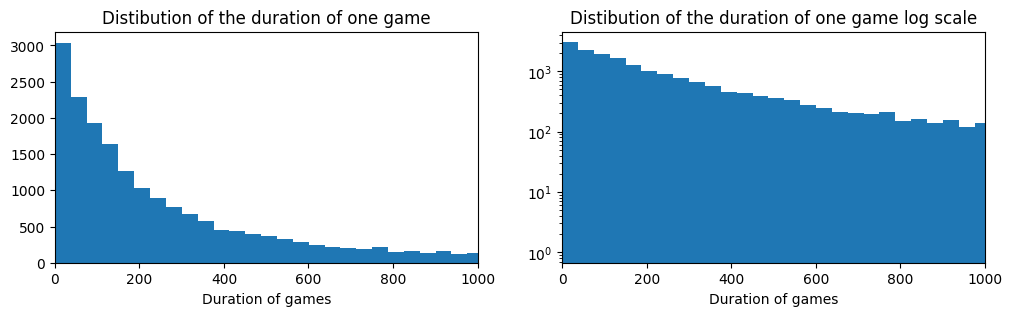

In [30]:
fig,axs = plt.subplots(1,2,figsize = (12,3))

axs[0].hist(df_lim100["time_played"],bins = 1000)
axs[0].set_title("Distibution of the duration of one game")
axs[0].set_xlabel("Duration of games")
axs[0].set_xlim([0,1000])

axs[1].hist(df_lim100["time_played"],bins = 1000)
axs[1].set_title("Distibution of the duration of one game log scale")
axs[1].set_xlabel("Duration of games")
axs[1].set_yscale("log")
axs[1].set_xlim([0,1000])

plt.show()

In [147]:
# learning parts
# big dataset:

df_paths = df_unfinished_paths.merge(df_finished_paths,how="outer").fillna(0)
df_paths['nbr_game'] = df_paths.groupby('hashedIpAddress')['hashedIpAddress'].transform('count')
#discarding people that played less than 2 games:
df_paths = df_paths[df_paths['nbr_game']>1]
df_paths = df_paths[df_paths['hashedIpAddress']!=0]


df_paths["winned?"] = (df_paths["type"]==0).astype(int)

#player_stat = df_paths.sort_values(by='timestamp').groupby('hashedIpAddress')
unique_ip = df_paths['hashedIpAddress'].unique()
df_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,nbr_loss,time_spent,nbr_timeout,time_spent_losing,rating,nbr_win,time_spent_winning,nbr_game,winned?
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2.0,1857.0,1.0,57.0,0.0,0.0,0.0,2,0
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2.0,1857.0,1.0,57.0,0.0,0.0,0.0,2,0
7,6d136e371e42474f,1297102070,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart,5.0,5873.0,3.0,473.0,0.0,0.0,0.0,175,0
8,6d136e371e42474f,1297102100,19,Logic,Moon_landing,restart,5.0,5873.0,3.0,473.0,0.0,0.0,0.0,175,0
9,6d136e371e42474f,1297104110,2006,Logic;Computer_science;Science;Physical_scienc...,Moon_landing,timeout,5.0,5873.0,3.0,473.0,0.0,0.0,0.0,175,0


In [169]:
stats_list = []
for ip in tqdm(unique_ip):
    L = df_paths[df_paths['hashedIpAddress']==ip].sort_values(by='timestamp')['winned?'].to_numpy()
    stats_list.append(L)
    

100%|███████████████████████████████████████████████████████████████████████████| 10543/10543 [01:17<00:00, 136.49it/s]


In [174]:
df_learning = pd.DataFrame(stats_list)

In [220]:
N=100
df_score = pd.DataFrame({'attempt':np.arange(1,N+1,1), 'score':df_learning.mean()[0:N]})
df_score.head()

res = smf.ols(formula= "score ~ attempt", data=df_score).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     42.46
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           3.13e-09
Time:                        12:39:45   Log-Likelihood:                 155.77
No. Observations:                 100   AIC:                            -307.5
Df Residuals:                      98   BIC:                            -302.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6669      0.010     64.288      0.000       0.646       0.688
attempt        0.0012      0.000      6.516      0.000       0.001       0.002
==============================================================================
Omnibus:                        0.826   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.510
Skew:                           0.165   Prob(JB):                        0.775
Kurtosis:                       3.114   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

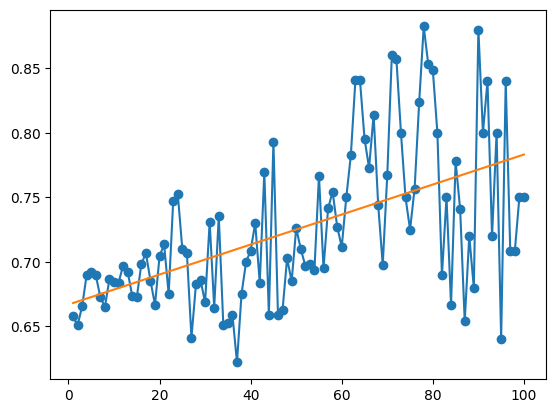

In [221]:
reg_params = res.params
intercept = reg_params[0]
slope = reg_params[1]

plt.scatter(df_score["attempt"],df_score["score"])
plt.plot(df_score["attempt"],df_score["score"],df_score["attempt"],intercept + df_score["attempt"]*slope)


plt.show()


From the regression results table, the p-value of the regression is 0.000, it is inferior to a confidence interval of 0.001. Therefore, we can reject the null hypothesis assuming that the win-rate is independant of the number of the attempt in chronological orde.
The table above shows that the win rate increase the more people play the game. This would mean that there is an observed learning as people plays.

# IDEE: Extract the strategy used by players: Extract the number of click, avg time by clicks, + in fct of time as people learn mechanics of the game...

## Link to others: for data-story how they get better: by clicking on the right/left/top/bottom (Roge), number of clicks/paths (Tev?), 

## Link tev-emilien?: does events influence badly the choice of the path

### Time spend in fct of attempts:
For this we will only account for games winned to see if they learn to play the game better.


The issue with game lost and why we don't take them into account is that:
 - restarts tends to reduce significantly the time of the game played beacuse they often restart early
 - timeout are most of the time game were people stop playing quite early and they would therefore influence the time to go down if we remove the 30min of the time of the average time up by a lot if we don't.

In [8]:
unique_ip_win = df_finished_paths["hashedIpAddress"].unique()

In [229]:
stats_list = []
for ip in tqdm(unique_ip_win):
    L = df_finished_paths[df_finished_paths['hashedIpAddress']==ip].sort_values(by='timestamp')['durationInSec'].to_numpy()
    stats_list.append(L)

100%|███████████████████████████████████████████████████████████████████████████| 14245/14245 [01:25<00:00, 166.04it/s]


In [230]:
df_learning_time = pd.DataFrame(stats_list)
df_learning_time.head()

,0,1,2,3,4,5,6,7,8,9,...,4855,4856,4857,4858,4859,4860,4861,4862,4863,4864
0,452.0,128.0,166.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,151.0,74.0,148.0,70.0,100.0,45.0,88.0,75.0,76.0,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29.0,10.0,52.0,48.0,168.0,91.0,16.0,86.0,33.0,138.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,120.0,37.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,175.0,79.0,106.0,187.0,247.0,63.0,26.0,652.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
N=100
df_score = pd.DataFrame({'attempt':np.arange(1,N+1,1), 'time_avg':df_learning_time.mean()[0:N]})

res = smf.ols(formula= "time_avg ~ attempt", data=df_score).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               time_avg   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     9.188
Date:                Sun, 04 Dec 2022   Prob (F-statistic):            0.00312
Time:                        18:15:54   Log-Likelihood:                -453.63
No. Observations:                 100   AIC:                             911.3
Df Residuals:                      98   BIC:                             916.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    143.9386      4.597     31.309      0.000     134.815     153.062
attempt       -0.2396      0.079     -3.031      0.003      -0.396      -0.083
==============================================================================
Omnibus:                        0.995   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                0.879
Skew:                           0.228   Prob(JB):                        0.644
Kurtosis:                       2.941   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

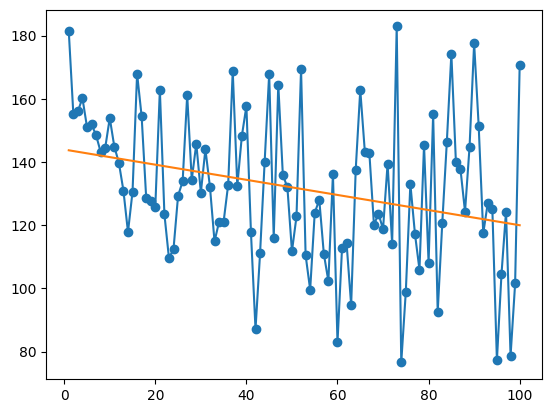

In [242]:
reg_params = res.params
intercept = reg_params[0]
slope = reg_params[1]

plt.scatter(df_score["attempt"],df_score["time_avg"])
plt.plot(df_score["attempt"],df_score["time_avg"],df_score["attempt"],intercept + df_score["attempt"]*slope)

plt.show()

From the regression results table, the p-value of the regression is 0.003, it is inferior to a confidence interval of 0.005. Therefore, we can reject the null hypothesis assuming that the duration of a game is independant of the number of the attempt in chronological orde.
The table above shows that the duration of a game decrease the more people play the game. This would mean that there is an observed learning as people plays as players get better and win more rapidely.

### Decoding evolution of strategies:

Deriving length of paths and average time per click:

In [3]:
df_finished_paths['path_list'] =  df_finished_paths['path'].str.split(';')
df_finished_paths['len_path'] = df_finished_paths['path_list'].str.len()
df_finished_paths['click_time'] = df_finished_paths['durationInSec'] / df_finished_paths["len_path"]
df_finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_list,len_path,click_time
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"[14th_century, 15th_century, 16th_century, Pac...",9,18.444444
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,17.600000
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"[14th_century, Niger, Nigeria, British_Empire,...",8,17.250000
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"[14th_century, Renaissance, Ancient_Greece, Gr...",4,9.250000
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,25.000000


In [275]:
click_list = []
click_time_list = []
for ip in tqdm(unique_ip_win):
    click_list.append(df_finished_paths[df_finished_paths['hashedIpAddress']==ip].sort_values(by='timestamp')['len_path'].to_numpy())
    click_time_list.append(df_finished_paths[df_finished_paths['hashedIpAddress']==ip].sort_values(by='timestamp')['click_time'].to_numpy())

100%|████████████████████████████████████████████████████████████████████████████| 14245/14245 [03:46<00:00, 63.00it/s]


In [280]:
df_click_strategy = pd.DataFrame(click_list)
df_click_strategy.head()

,0,1,2,3,4,5,6,7,8,9,...,4855,4856,4857,4858,4859,4860,4861,4862,4863,4864
0,11.0,3.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.0,4.0,6.0,4.0,5.0,4.0,5.0,5.0,4.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,4.0,4.0,5.0,22.0,4.0,3.0,6.0,5.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.0,5.0,7.0,10.0,12.0,5.0,5.0,13.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [277]:
df_click_time = pd.DataFrame(click_time_list)
df_click_time.head()

,0,1,2,3,4,5,6,7,8,9,...,4855,4856,4857,4858,4859,4860,4861,4862,4863,4864
0,41.090909,42.666667,18.444444,12.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25.166667,18.500000,24.666667,17.500000,20.000000,11.25,17.600000,15.000000,19.0,27.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.250000,2.500000,13.000000,9.600000,7.636364,22.75,5.333333,14.333333,6.6,17.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17.142857,9.250000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25.000000,15.800000,15.142857,18.700000,20.583333,12.60,5.200000,50.153846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [282]:
df_strategy = pd.DataFrame({'attempt':np.arange(1,N+1,1), 'nbr_click':df_click_strategy.mean()[0:N], 'click_speed':df_click_time.mean()[0:N]})

res = smf.ols(formula= "nbr_click ~ attempt", data=df_strategy).fit()
res1 =smf.ols(formula= "click_speed ~ attempt", data=df_strategy).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            click_speed   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     60.74
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           6.97e-12
Time:                        19:11:48   Log-Likelihood:                -213.31
No. Observations:                 100   AIC:                             430.6
Df Residuals:                      98   BIC:                             435.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.4359      0.416     49.154      0.000      19.611      21.261
attempt       -0.0557      0.007     -7.794      0.000      -0.070      -0.042
==============================================================================
Omnibus:                       15.805   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.942
Skew:                           0.920   Prob(JB):                     0.000127
Kurtosis:                       3.961   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [283]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            click_speed   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     60.74
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           6.97e-12
Time:                        19:12:04   Log-Likelihood:                -213.31
No. Observations:                 100   AIC:                             430.6
Df Residuals:                      98   BIC:                             435.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.4359      0.416     49.154      0.000      19.611      21.261
attempt       -0.0557      0.007     -7.794      0.000      -0.070      -0.042
==============================================================================
Omnibus:                       15.805   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.942
Skew:                           0.920   Prob(JB):                     0.000127
Kurtosis:                       3.961   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

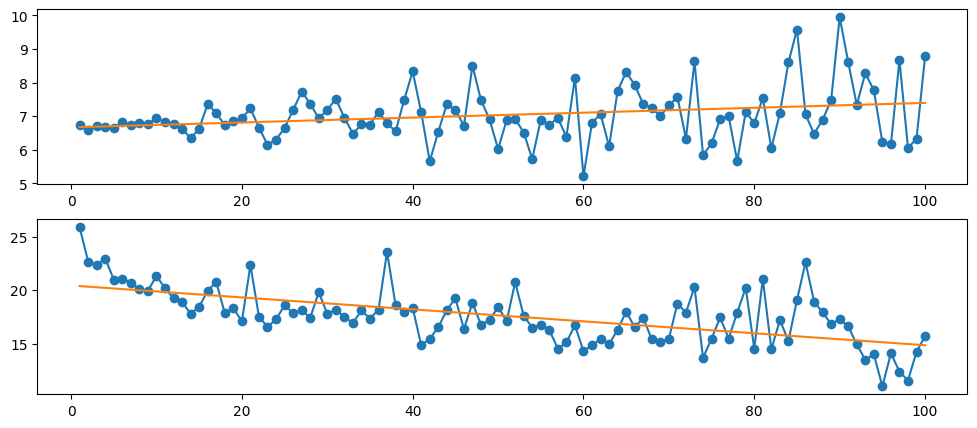

In [288]:
reg_params = res.params
intercept = reg_params[0]
slope = reg_params[1]

reg1_params = res1.params
intercept_1 = reg1_params[0]
slope_1 = reg1_params[1]

fig, axs = plt.subplots(2,figsize=(12,5))

axs[0].scatter(df_strategy["attempt"],df_strategy["nbr_click"])
axs[1].scatter(df_strategy["attempt"],df_strategy["click_speed"])
axs[0].plot(df_strategy["attempt"],df_strategy["nbr_click"],df_strategy["attempt"],intercept + df_strategy["attempt"]*slope)
axs[1].plot(df_strategy["attempt"],df_strategy["click_speed"],df_strategy["attempt"],intercept_1 + df_strategy["attempt"]*slope_1)

plt.show()

From the results above we can see that the number of clicks stays quite constant on the range, meaning that the strategy on the number of click don't really evolve, they just get better as they plays

### How they see the difficulty the more they play: 

In [306]:
rated_paths = df_finished_paths[df_finished_paths["rating"].fillna(0) != 0]
unrated_paths = df_finished_paths[df_finished_paths["rating"].fillna(0) == 0]
print("Number of paths rated: %d \t Number of paths unrated: %d"%(len(rated_paths),len(unrated_paths)))

Number of paths rated: 28501 	 Number of paths unrated: 22817


In [300]:
"""rate_list = []
unique_ip_rated = rated_paths["hashedIpAddress"].unique()
for ip in tqdm(unique_ip_rated):
    rate_list.append(rated_paths[rated_paths['hashedIpAddress']==ip].sort_values(by='timestamp')['rating'].to_numpy())"""

100%|█████████████████████████████████████████████████████████████████████████████| 9572/9572 [00:43<00:00, 217.78it/s]


In [302]:
"""df_ratings = pd.DataFrame(rate_list)
df_ratings.head()"""

,0,1,2,3,4,5,6,7,8,9,...,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872
0,2.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,1.0,3.0,5.0,3.0,2.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,2.0,2.0,3.0,3.0,3.0,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


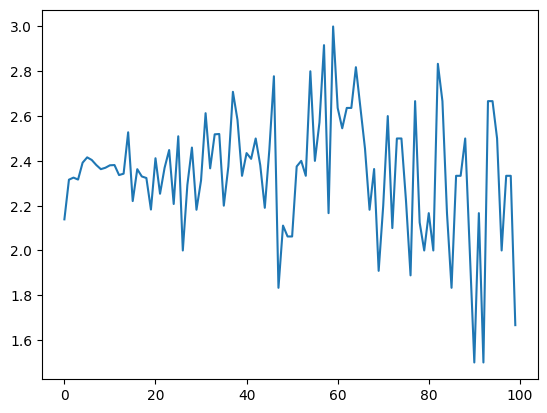

In [303]:
"""plt.plot(np.arange(0,100,1),df_ratings.mean()[0:100])
plt.show()"""

In [9]:
rate_list = []
for ip in tqdm(unique_ip_win):
    rate_list.append(df_finished_paths[df_finished_paths['hashedIpAddress']==ip].sort_values(by='timestamp')['rating'].to_numpy())

100%|███████████████████████████████████████████████████████████████████████████| 14245/14245 [02:10<00:00, 108.81it/s]


In [10]:
df_ratings = pd.DataFrame(rate_list)
df_ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4855,4856,4857,4858,4859,4860,4861,4862,4863,4864
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,1.0,NaN,1.0,3.0,NaN,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,1.0,3.0,5.0,3.0,2.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_difficulty = pd.DataFrame({'attempt':np.arange(1,N+1,1), 'difficulty':df_ratings.mean()[0:N]})

res = smf.ols(formula= "difficulty ~ attempt", data=df_difficulty).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difficulty   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     31.55
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.82e-07
Time:                        18:14:05   Log-Likelihood:                -9.0655
No. Observations:                 100   AIC:                             22.13
Df Residuals:                      98   BIC:                             27.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2061      0.054     40.909      0.000       2.099       2.313
attempt        0.0052      0.001      5.617      0.000       0.003       0.007
==============================================================================
Omnibus:                       43.318   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.620
Skew:                           1.332   Prob(JB):                     8.13e-41
Kurtosis:                       9.100   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

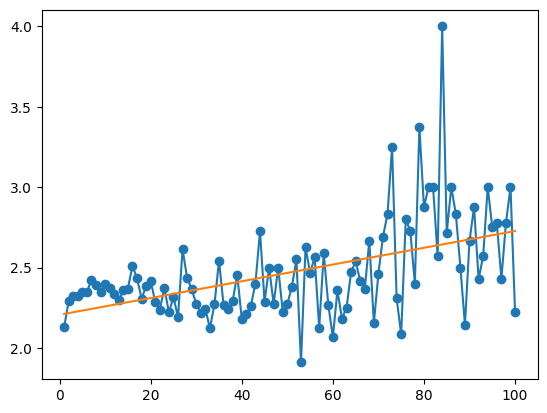

In [20]:
reg_params = res.params
intercept = reg_params[0]
slope = reg_params[1]

plt.scatter(df_difficulty["attempt"],df_difficulty["difficulty"])

plt.plot(df_difficulty["attempt"],df_difficulty["difficulty"],df_difficulty["attempt"], intercept + slope * df_difficulty["attempt"])
plt.show()

In [5]:
print(df_finished_paths["len_path"].mean())

6.757434038738844
